In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)

import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')

import warnings
warnings.filterwarnings('ignore')

from time import time

import matplotlib.ticker as tkr
%matplotlib inline

from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
    
import math

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [235]:
stock_name ='AAPL'
starting_date ='2012-4-1'
ending_date = '2013-11-25'
n =5

In [265]:
df = pd.read_csv(f'E:\Semesters\Fyp prepation\Dataset\AAPL_Stock_Dataset\{stock_name}_STOCK_SENTI_SCORE_{n}_BACKWARD_{starting_date}_TO_{ending_date}_.csv')

In [266]:
#df.drop(df.columns[0], axis=1, inplace = True)
df =df.rename(columns={'Date':'time'})
df.time = pd.to_datetime(df.time)
df = df.set_index('time')
df

,Unnamed: 0,Target-5,Target-4,Target-3,Target-2,Target-1,Target,pos_sentm,neg_sentm,sentm_score
time,,,,,,,,,,
2012-04-03,0,21.9457,22.0579,21.7807,21.4125,22.0939,22.4757,0.7664,0.2336,4
2012-04-04,1,22.0579,21.7807,21.4125,22.0939,22.4757,22.2968,0.3650,0.6350,2
2012-04-05,2,21.7807,21.4125,22.0939,22.4757,22.2968,22.6314,0.3780,0.6220,2
2012-04-09,3,21.4125,22.0939,22.4757,22.2968,22.6314,22.7225,0.2384,0.7616,2
2012-04-10,4,22.0939,22.4757,22.2968,22.6314,22.7225,22.4443,0.6347,0.3653,4
...,...,...,...,...,...,...,...,...,...,...
2013-11-19,386,18.5718,18.5939,18.8629,18.7496,18.5225,18.5554,0.1818,0.2182,1
2013-11-20,387,18.5939,18.8629,18.7496,18.5225,18.5554,18.3929,0.1627,0.5040,1
2013-11-21,388,18.8629,18.7496,18.5225,18.5554,18.3929,18.6121,0.5229,0.4771,3


In [267]:
df

,Unnamed: 0,Target-5,Target-4,Target-3,Target-2,Target-1,Target,pos_sentm,neg_sentm,sentm_score
time,,,,,,,,,,
2012-04-03,0,21.9457,22.0579,21.7807,21.4125,22.0939,22.4757,0.7664,0.2336,4
2012-04-04,1,22.0579,21.7807,21.4125,22.0939,22.4757,22.2968,0.3650,0.6350,2
2012-04-05,2,21.7807,21.4125,22.0939,22.4757,22.2968,22.6314,0.3780,0.6220,2
2012-04-09,3,21.4125,22.0939,22.4757,22.2968,22.6314,22.7225,0.2384,0.7616,2
2012-04-10,4,22.0939,22.4757,22.2968,22.6314,22.7225,22.4443,0.6347,0.3653,4
...,...,...,...,...,...,...,...,...,...,...
2013-11-19,386,18.5718,18.5939,18.8629,18.7496,18.5225,18.5554,0.1818,0.2182,1
2013-11-20,387,18.5939,18.8629,18.7496,18.5225,18.5554,18.3929,0.1627,0.5040,1
2013-11-21,388,18.8629,18.7496,18.5225,18.5554,18.3929,18.6121,0.5229,0.4771,3


In [268]:
#result= pd.read_pickle("E:\Semesters\Fyp prepation\Stock-Market-Prediction-Using-LSTM-and-Online-News-Sentiment-Analysis\data sets\data_to_paper_microsoft_case.pkl")

# original time serie (Y)
y = df.Target.values 
# y= df.close.values
y = y.astype('float32')
y = np.reshape(y, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
y = scaler.fit_transform(y)



# training and testing settings (size)
percent_of_training = 0.55
train_size = int(len(y) * percent_of_training)
test_size = len(y) - train_size
# 
train_y, test_y = y[0:train_size,:], y[train_size:len(y),:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    #for i in range(len(dataset)-look_back-1):
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [269]:
look_back = 7


# features of the original time serie (y)
X_train_features_1, y_train = create_dataset(train_y, look_back)
X_test_features_1, y_test = create_dataset(test_y, look_back)




# join the all the features in one
## reshape arrays
X_train_features = np.reshape(X_train_features_1, (X_train_features_1.shape[0], 1, X_train_features_1.shape[1]))
X_test_features  = np.reshape(X_test_features_1, (X_test_features_1.shape[0], 1, X_test_features_1.shape[1]))



In [76]:
l=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
# for i in range(len(l)-3-1):
#     print(l[i:(i+3)])

l[-2:]

[16, 17]

In [270]:
model = Sequential()
model.add(LSTM(200, input_shape=(X_train_features.shape[1], X_train_features.shape[2])))
model.add(Dropout(0.20))
model.add(Dense(5))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train_features,y_train, epochs=300, batch_size=25, validation_data=(X_test_features, y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=0, shuffle=False)

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 200)               166400    
                                                                 
 dropout_7 (Dropout)         (None, 200)               0         
                                                                 
 dense_7 (Dense)             (None, 5)                 1005      
                                                                 
Total params: 167,405
Trainable params: 167,405
Non-trainable params: 0
_________________________________________________________________


In [271]:
train_predict = model.predict(X_train_features)
test_predict  = model.predict(X_test_features)




#train_predict = scaler.inverse_transform(train_predict)
#Y_train = scaler.inverse_transform(y_train)
#test_predict = scaler.inverse_transform(test_predict)
#Y_test = scaler.inverse_transform(y_test)


print('Train Mean Absolute Error:', mean_absolute_error(np.reshape(y_train,(y_train.shape[0],1)), train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(np.reshape(y_train,(y_train.shape[0],1)), train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(np.reshape(y_test,(y_test.shape[0],1)), test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(np.reshape(y_test,(y_test.shape[0],1)), test_predict[:,0])))

6/6 [==============================] - 0s 3ms/step
Train Mean Absolute Error: 0.049244877
Train Root Mean Squared Error: 0.06114906
Test Mean Absolute Error: 0.025315817
Test Root Mean Squared Error: 0.032829758


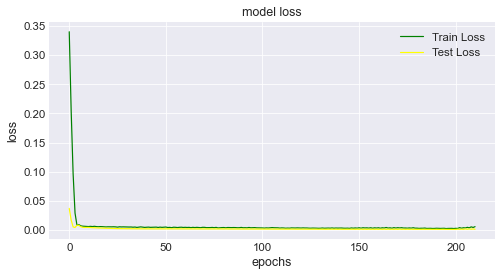

In [272]:
plt.figure(figsize=(8,4))
plt.style.use('seaborn-dark')

plt.plot(history.history['loss'], label='Train Loss',color="green")
plt.plot(history.history['val_loss'], label='Test Loss',color = "yellow")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.grid()

plt.show();

In [69]:
train_predict

array([[0.7369279 , 0.7378956 , 0.7358806 , 0.7448205 , 0.7352289 ],
       [0.72009635, 0.72223485, 0.72121507, 0.72863674, 0.7181683 ],
       [0.68937194, 0.6921749 , 0.6909999 , 0.6997074 , 0.68897927],
       ...,
       [0.15112445, 0.15360273, 0.15636069, 0.15909006, 0.15184486],
       [0.15044695, 0.15044767, 0.15365191, 0.1571646 , 0.1507613 ],
       [0.15013638, 0.15140998, 0.15622103, 0.15778363, 0.15253146]],
      dtype=float32)

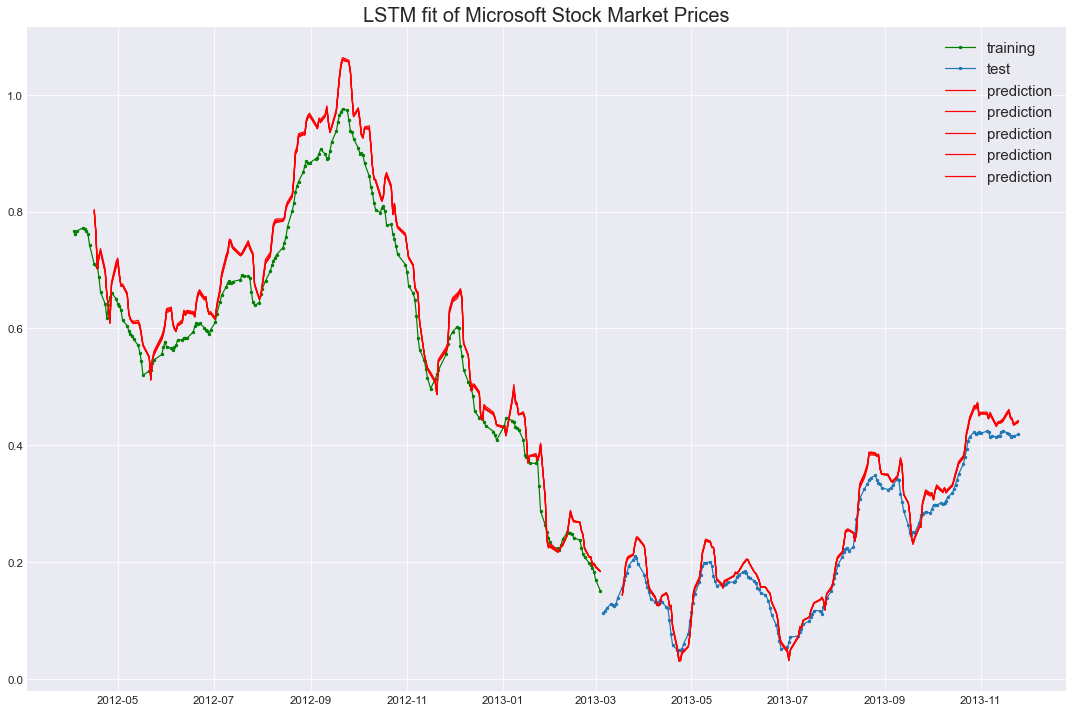

In [273]:
time_y_train = pd.DataFrame(data = train_y, index = df[0:train_size].index,columns= [""])
time_y_test  = pd.DataFrame(data = test_y, index = df[train_size:].index,columns= [""])
time_y_train_prediction = pd.DataFrame(data = train_predict, index = time_y_train[8:].index,columns= ["pred","pred+1","pred+2","pred+3","pred+4"])
time_y_test_prediction  = pd.DataFrame(data = test_predict, index = time_y_test[8:].index,columns= ["pred","pred+1","pred+2","pred+3","pred+4"])

#time_y_test = time_y_test[:-7]

plt.style.use('seaborn-dark')
plt.figure(figsize=(15,10))

plt.plot(time_y_train.ewm(span=7, adjust=False).mean(),label = "training",color ="green",marker='.')
plt.plot(time_y_test.ewm(span=7, adjust=False).mean(),label = "test",marker='.')
plt.plot(time_y_train_prediction,color="red",label = "prediction")
plt.plot(time_y_test_prediction,color="red")
plt.title("LSTM fit of Microsoft Stock Market Prices",size = 20)
plt.tight_layout()
sns.despine(top=True)
plt.ylabel('', size=15)
plt.xlabel('', size=15)
plt.legend(fontsize=15)
plt.grid()

plt.show();

In [196]:
fg =time_y_train_prediction["pred"]
fg.reset_index(drop =True).values

array([0.08331805, 0.08308089, 0.08204351, 0.08391772, 0.08511366,
       0.08442088, 0.08109302, 0.07979232, 0.07732529, 0.07463461,
       0.07241014, 0.07063805, 0.07004824, 0.07141771, 0.07142416,
       0.07221776, 0.07686029, 0.08078353, 0.08278262, 0.08377154,
       0.08384416, 0.08202811, 0.0808773 , 0.07868282, 0.07502256,
       0.07158631, 0.06938943, 0.06696492, 0.0672463 , 0.06702877,
       0.06938028, 0.07323103, 0.07841364, 0.08372457, 0.08605482,
       0.08776039, 0.08564723, 0.08366115, 0.08237135, 0.08084708,
       0.08037739, 0.0789548 , 0.07641353, 0.07537353, 0.07244167,
       0.06825419, 0.06237052, 0.05438412, 0.05157042, 0.04963113,
       0.04774275, 0.04768431, 0.04789019, 0.04819582, 0.05162272,
       0.05186976, 0.05284747, 0.05527078, 0.05640795, 0.05820185,
       0.06012668, 0.06168769, 0.06318408, 0.06489274, 0.06720922,
       0.06849959, 0.07105865, 0.07283445, 0.0738352 , 0.07362142,
       0.07165624, 0.07128993, 0.06993853, 0.06797478, 0.06782

In [197]:
vf =time_y_train.reset_index(drop=True)
vf[8:].iloc[:,0].values

array([0.0565815 , 0.05721152, 0.06103083, 0.0550065 , 0.03224793,
       0.05579403, 0.0505178 , 0.03827226, 0.03779978, 0.04992718,
       0.04642281, 0.04736784, 0.05268341, 0.05351028, 0.07020515,
       0.06937829, 0.06079459, 0.05016345, 0.05043906, 0.04268223,
       0.05177778, 0.05575463, 0.04130411, 0.02984607, 0.03535852,
       0.03520104, 0.04858845, 0.05122656, 0.06689769, 0.06323585,
       0.06599206, 0.07071704, 0.05666023, 0.05929837, 0.04209161,
       0.05299839, 0.05693588, 0.05886525, 0.06032211, 0.04685596,
       0.03449228, 0.03874475, 0.03764227, 0.02905858, 0.01614368,
       0.        , 0.02531797, 0.02775919, 0.02464861, 0.02929482,
       0.02752298, 0.01287556, 0.03071231, 0.03122416, 0.03413793,
       0.03992599, 0.03728789, 0.03413793, 0.03118482, 0.04283974,
       0.04429659, 0.04721034, 0.05347091, 0.04547784, 0.04953343,
       0.04752532, 0.05134466, 0.04311535, 0.03468916, 0.04823405,
       0.04055598, 0.03405917, 0.04571408, 0.05154154, 0.04685

In [246]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score


# Assuming you have forecasted and true stock prices as NumPy arrays or pandas Series
# For demonstration purposes, let's create example NumPy arrays:
forecasted_prices = vf[8:].iloc[:,0].values
true_prices = fg.reset_index(drop =True).values

forecasted_prices= scaler.inverse_transform(np.reshape(forecasted_prices, (-1, 1)))
true_prices = scaler.inverse_transform(np.reshape(true_prices, (-1, 1)))
# Define a deviation threshold (you can adjust this based on your specific requirements)
deviation_threshold = 0.6

# Calculate the absolute difference between forecasted and true prices
price_difference = np.abs(forecasted_prices - true_prices)

# Determine whether the predictions are within the deviation limit or not
within_deviation_limit = price_difference <= deviation_threshold

# Convert boolean values to binary labels (True: 1, False: 0)
predicted_labels = within_deviation_limit.astype(int)
true_labels = np.ones_like(predicted_labels)

# Compute the confusion matrix
matrix_confusion = confusion_matrix(true_labels, predicted_labels)

# Compute F1 score
f1 = f1_score(true_labels, predicted_labels)


# Create a DataFrame to visualize the confusion matrix
confusion_df = pd.DataFrame(matrix_confusion, index=['True', 'False'], columns=['Predicted True', 'Predicted False'])

# Output the confusion matrix and F1 score
print("Confusion Matrix:")
print(confusion_df)
print("\nF1 Score:", f1)

Confusion Matrix:
       Predicted True  Predicted False
True                0                0
False              45              780

F1 Score: 0.9719626168224299


In [338]:
def get_precision_attributes(n_days, tolerance,forecasted_prices_df, true_prices_df):
    
    try:
        true_prices_df =true_prices_df.reset_index(drop=True)
    except:
        pass
    
    true_prices = true_prices_df[n_days+1:].iloc[:,0].values
    
    try:
        forecasted_prices = forecasted_prices_df.reset_index(drop =True).values
    except:
        pass
    forecasted_prices= scaler.inverse_transform(np.reshape(forecasted_prices, (-1, 1)))
    true_prices = scaler.inverse_transform(np.reshape(true_prices, (-1, 1)))
    # Define a deviation threshold (you can adjust this based on your specific requirements)
    deviation_threshold = tolerance

    # Calculate the absolute difference between forecasted and true prices
    price_difference = np.abs(forecasted_prices - true_prices)

    # Determine whether the predictions are within the deviation limit or not
    within_deviation_limit = price_difference <= deviation_threshold

    # Convert boolean values to binary labels (True: 1, False: 0)
    predicted_labels = within_deviation_limit.astype(int)
    
    true_labels = np.ones_like(predicted_labels)
    # true_labels = within_deviation_limit.astype(int)


    # Compute the confusion matrix
    matrix_confusion = confusion_matrix(true_labels, predicted_labels)

    # Compute F1 score
    f1 = f1_score(true_labels, predicted_labels)


    # Create  DataFrame to visualize the confusion matrix
    confusion_df = pd.DataFrame(matrix_confusion, index=['True', 'False'], columns=['Predicted True', 'Predicted False'])
    
    return confusion_df, f1
    

In [ ]:
confusion_df, f1=get_precision_attributes(7, 0.7,time_y_train_prediction["pred"],time_y_train)

confusion_df

In [310]:
f1

0.771513353115727

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [321]:
df = pd.read_csv(f'E:\Semesters\Fyp prepation\Dataset\AAPL_Stock_Dataset\{stock_name}_STOCK_SENTI_SCORE_{n}_BACKWARD_{starting_date}_TO_{ending_date}_.csv')

In [322]:
df.drop(df.columns[0], axis=1, inplace = True)
df.set_index('Date')

,Target-5,Target-4,Target-3,Target-2,Target-1,Target,pos_sentm,neg_sentm,sentm_score
Date,,,,,,,,,
2012-04-03,21.9457,22.0579,21.7807,21.4125,22.0939,22.4757,0.7664,0.2336,4
2012-04-04,22.0579,21.7807,21.4125,22.0939,22.4757,22.2968,0.3650,0.6350,2
2012-04-05,21.7807,21.4125,22.0939,22.4757,22.2968,22.6314,0.3780,0.6220,2
2012-04-09,21.4125,22.0939,22.4757,22.2968,22.6314,22.7225,0.2384,0.7616,2
2012-04-10,22.0939,22.4757,22.2968,22.6314,22.7225,22.4443,0.6347,0.3653,4
...,...,...,...,...,...,...,...,...,...
2013-11-19,18.5718,18.5939,18.8629,18.7496,18.5225,18.5554,0.1818,0.2182,1
2013-11-20,18.5939,18.8629,18.7496,18.5225,18.5554,18.3929,0.1627,0.5040,1
2013-11-21,18.8629,18.7496,18.5225,18.5554,18.3929,18.6121,0.5229,0.4771,3


In [323]:
#result= pd.read_pickle("data sets/data_to_paper_microsoft_case.pkl")

# original time serie (Y)
y = df.Target.values #numpy.ndarray
y = y.astype('float32')
y = np.reshape(y, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
y = scaler.fit_transform(y)


# extra information: features of the sentiment analysis
X = df.pos_sentm.values
X = X.astype('float32')
X = np.reshape(X, (-1, 1))

# training and testing settings (size)
percent_of_training = 0.7
train_size = int(len(y) * percent_of_training)
test_size = len(y) - train_size
# 
train_y, test_y = y[0:train_size,:], y[train_size:len(y),:]
train_x, test_x = X[0:train_size,:], X[train_size:len(X),:]



def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [324]:
look_back = 7


# features of the original time serie (y)
X_train_features_1, y_train = create_dataset(train_y, look_back)
X_test_features_1, y_test = create_dataset(test_y, look_back)


# calculate extra features in (X)
X_train_features_2, auxiliar_1 = create_dataset(train_x, look_back)
X_test_features_2, auxiliar_2 = create_dataset(test_x, look_back)


# join the all the features in one
## reshape arrays
X_train_features_1 = np.reshape(X_train_features_1, (X_train_features_1.shape[0], 1, X_train_features_1.shape[1]))
X_test_features_1  = np.reshape(X_test_features_1, (X_test_features_1.shape[0], 1, X_test_features_1.shape[1]))
X_train_features_2 = np.reshape(X_train_features_2, (X_train_features_2.shape[0], 1, X_train_features_2.shape[1]))
X_test_features_2  = np.reshape(X_test_features_2, (X_test_features_2.shape[0], 1, X_test_features_2.shape[1]))
## put all together
X_train_all_features = np.append(X_train_features_1,X_train_features_2,axis=1)
X_test_all_features = np.append(X_test_features_1,X_test_features_2,axis=1)


In [325]:
model = Sequential()
model.add(LSTM(200, input_shape=(X_train_all_features.shape[1], X_train_all_features.shape[2])))
model.add(Dropout(0.20))
model.add(Dense(1)) 
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train_all_features,y_train, epochs=300, batch_size=25, validation_data=(X_test_all_features, y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=0, shuffle=False)

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 200)               166400    
                                                                 
 dropout_9 (Dropout)         (None, 200)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 201       
                                                                 
Total params: 166,601
Trainable params: 166,601
Non-trainable params: 0
_________________________________________________________________


In [326]:
train_predict = model.predict(X_train_all_features)
test_predict  = model.predict(X_test_all_features)




#train_predict = scaler.inverse_transform(train_predict)
#Y_train = scaler.inverse_transform(y_train)
#test_predict = scaler.inverse_transform(test_predict)
#Y_test = scaler.inverse_transform(y_test)


print('Train Mean Absolute Error:', mean_absolute_error(np.reshape(y_train,(y_train.shape[0],1)), train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(np.reshape(y_train,(y_train.shape[0],1)), train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(np.reshape(y_test,(y_test.shape[0],1)), test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(np.reshape(y_test,(y_test.shape[0],1)), test_predict[:,0])))

4/4 [==============================] - 0s 5ms/step
Train Mean Absolute Error: 0.11161178
Train Root Mean Squared Error: 0.12512365
Test Mean Absolute Error: 0.06674401
Test Root Mean Squared Error: 0.07770069


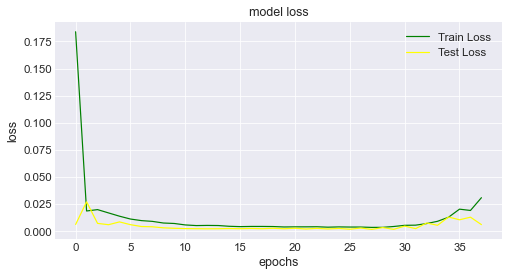

In [327]:
plt.figure(figsize=(8,4))
plt.style.use('seaborn-dark')


plt.plot(history.history['loss'], label='Train Loss',color="green")
plt.plot(history.history['val_loss'], label='Test Loss',color = "yellow")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.grid()

plt.show();

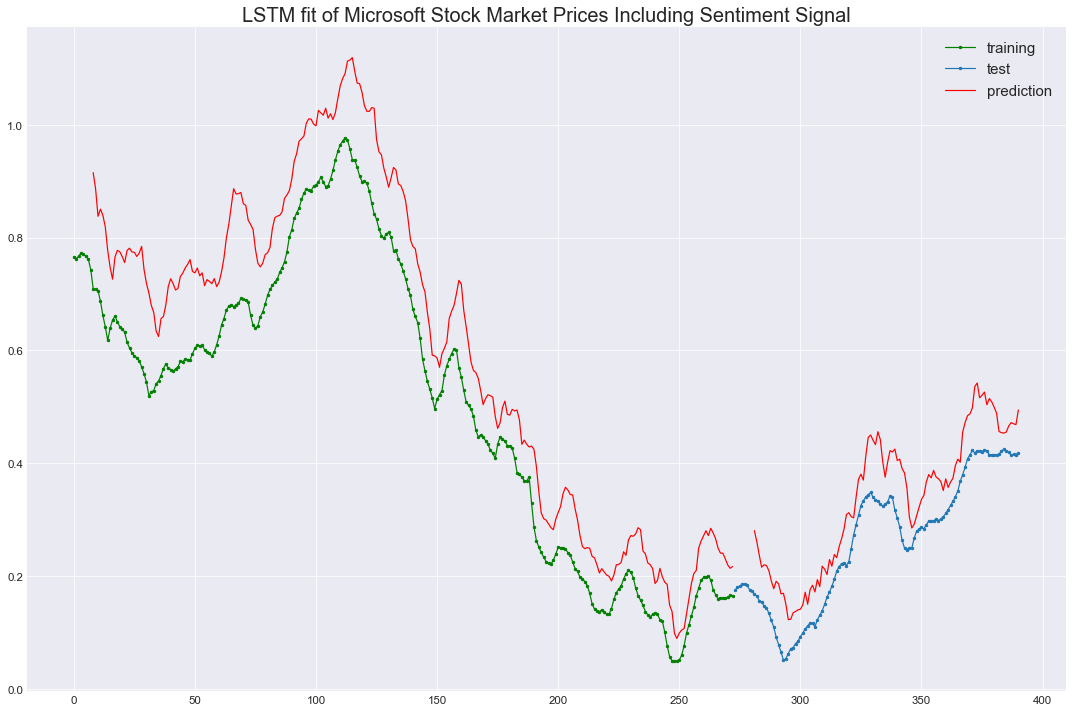

In [328]:
time_y_train = pd.DataFrame(data = train_y, index = df[0:train_size].index,columns= [""])
time_y_test  = pd.DataFrame(data = test_y, index = df[train_size:].index,columns= [""])

time_y_train_prediction = pd.DataFrame(data = train_predict, index = time_y_train[8:].index,columns= [""])
time_y_test_prediction  = pd.DataFrame(data = test_predict, index = time_y_test[8:].index,columns= [""])


plt.style.use('seaborn-dark')
plt.figure(figsize=(15,10))

plt.plot(time_y_train.ewm(span=7, adjust=False).mean(),label = "training",color ="green",marker='.')
plt.plot(time_y_test.ewm(span=7, adjust=False).mean(),label = "test",marker='.')
plt.plot(time_y_train_prediction,color="red",label = "prediction")
plt.plot(time_y_test_prediction,color="red")
plt.title("LSTM fit of Microsoft Stock Market Prices Including Sentiment Signal",size = 20)
plt.tight_layout()
sns.despine(top=True)
plt.ylabel('', size=15)
plt.xlabel('', size=15)
plt.legend(fontsize=15)
plt.grid()

plt.show();

In [335]:
from Precision_Attributes import get_precision_attributes

In [346]:
confusion_df, f1=get_precision_attributes(7, 1.5,time_y_train_prediction,time_y_train)

confusion_df

,Predicted True,Predicted False
True,0,0
False,97,168


In [347]:
f1

0.7759815242494227